# Notes

1. be sure to use exponential RELU
2. dataset includes 4 classes, 9 test sujects
3. expect no spacial interdependency between channels
4. expect interdependacny in time-domain. Use Conv nets to get frequencies
5. input is 2D-array, where height is the umber of channels, width is time
6. aim is 76% accuracy
7. We do not even try hybrid/residual nets because it was said that it performs worse than Deep net

Simle NN:

We applied batch normalization,
as recommended in the original paper (Ioffe and Szegedy, 2015), to the output of convolutional
layers before the nonlinearity. Dropout randomly sets some inputs for a layer to zero in each
training update. It is meant to prevent co-adaption of different units and can be seen as analogous
to training an ensemble of networks. We drop out the inputs to all convolutional layers after the
first with a probability of 0.5. Finally, our new tied loss function is designed to further regularize
our cropped training (see Section 2.5.4 for an explanation).


Our deep ConvNet had four convolution-max-pooling blocks, with a special first block designed
to handle EEG input (see below), followed by three standard convolution-max-pooling blocks and
a dense softmax classification layer

Dropout for my conv layer is p=0.8 and for my fc layer is p=0.5. Interestingly, I saw the opposite trend where a low dropout number (I tried 0.2 out of curiosity) made overfitting worse and dropped my validation accuracy by 10-15%. Beside dropout, I didn't add any other regularization since that mainly helps with overfitting I believe. 

# Set up the environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# import tf
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K

# import os functions
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

# Load the data

### Read the files

In [3]:
X_test = np.load("./EEG_data/X_test.npy")
y_test = np.load("./EEG_data/y_test.npy") - 769
person_train_valid = np.load("./EEG_data/person_train_valid.npy")
X_train_valid = np.load("./EEG_data/X_train_valid.npy")
y_train_valid = np.load("./EEG_data/y_train_valid.npy") - 769
person_test = np.load("./EEG_data/person_test.npy")

### Shape of data

In [4]:
print("training/Valid data shape: {}".format(X_train_valid.shape))       # training data of many persons
print("Test data shape: {}".format(X_test.shape))                        # test data of many persons
print("Training/Valid target shape: {}".format(y_train_valid.shape))     # training labels of many persons
print("Test target shape: {}".format(y_test.shape))                      # test labels of many persons
print("Person train/valid  shape: {}".format(person_train_valid.shape))  # which person correspond to the trail in test set
print("Person test shape: {}".format(person_test.shape))                 # which person correspond to the trail in test set

training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid  shape: (2115, 1)
Person test shape: (443, 1)


### divide dataset into training and validation

In [5]:
perm = np.random.permutation(X_train_valid.shape[0])
num_train = int(0.8 * X_train_valid.shape[0])
num_valid = X_train_valid.shape[0] - num_train
X_train =  X_train_valid[perm[0:num_train]]
y_train =  y_train_valid[perm[0:num_train]]
X_valid = X_train_valid[perm[num_train: ]]
y_valid = y_train_valid[perm[num_train: ]]


print("Training data shape: {}".format(X_train.shape))
print("Training label shape: {}".format(y_train.shape))
print("Validation data shape: {}".format(X_valid.shape))
print("Validation label shape: {}".format(y_valid.shape))
print("Test data shape: {}".format(X_test.shape))
print("Test label shape: {}".format(y_test.shape))

Training data shape: (1692, 22, 1000)
Training label shape: (1692,)
Validation data shape: (423, 22, 1000)
Validation label shape: (423,)
Test data shape: (443, 22, 1000)
Test label shape: (443,)


### 1 person dataset

In [6]:
person_num = 0
indices_train_valid = np.where(person_train_valid == person_num)[0]
indices_test = np.where(person_test == person_num)[0]

single_person_X_train_valid = X_train_valid[indices_train_valid]
single_person_y_train_valid = y_train_valid[indices_train_valid]

perm = np.random.permutation(single_person_X_train_valid.shape[0])
num_train = int(0.8 * single_person_X_train_valid.shape[0])
num_valid = single_person_X_train_valid.shape[0] - num_train
single_person_X_train =  single_person_X_train_valid[perm[0:num_train]]
single_person_y_train =  single_person_y_train_valid[perm[0:num_train]]
single_person_X_valid = single_person_X_train_valid[perm[num_train: ]]
single_person_y_valid = single_person_y_train_valid[perm[num_train: ]]

single_person_X_test = X_test[indices_test]
single_person_y_test = y_test[indices_test]


print("Training data shape for 1 person: {}".format(single_person_X_train.shape))
print("Training label shape for 1 person: {}".format(single_person_y_train.shape))
print("Validation data shape for 1 person: {}".format(single_person_X_valid.shape))
print("Validation label shape for 1 person: {}".format(single_person_y_valid.shape))
print("Test data shape for 1 person: {}".format(single_person_X_test.shape))
print("Test label shape for 1 person: {}".format(single_person_y_test.shape))

Training data shape for 1 person: (189, 22, 1000)
Training label shape for 1 person: (189,)
Validation data shape for 1 person: (48, 22, 1000)
Validation label shape for 1 person: (48,)
Test data shape for 1 person: (50, 22, 1000)
Test label shape for 1 person: (50,)


# Shallow model 

### define activation functions

In [7]:
def Ksquare(x):
    return K.pow(x, 2)

def Klog(x):
    return K.log(x)

### Construct model

In [33]:
# input
shallow_input = layers.Input(shape=(22, 1000))

# conv accross time domain
r1 = layers.Reshape((22, 1000, 1))(shallow_input)
c1 = layers.Conv2D(40, (1, 25), strides=(1, 1), activation="elu")(r1)
t1 = tf.keras.layers.Permute((2, 3, 1))(c1)

# conv accross time domain
r2 = layers.Reshape((976, 40*22, 1))(t1)
c2 = layers.Conv2D(40, (1, 40*22), strides=(1, 1), activation="elu")(r2)

sq1 = layers.Activation(Ksquare)(c2)
r3 = layers.Reshape((976, 40, 1))(sq1)
apool1 = layers.AveragePooling2D(pool_size=(75, 1), strides=(15, 1))(r3)
                                 
log1 = layers.Activation(Klog)(apool1)
f1 = layers.Flatten()(log1)

# output
shallow_output = layers.Dense(4, activation="softmax")(f1)

In [34]:
shallow_model = keras.Model(inputs = shallow_input, outputs = shallow_output, name="shallow_model")
shallow_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

In [35]:
shallow_model.summary()

Model: "shallow_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 22, 1000)]        0         
_________________________________________________________________
reshape_23 (Reshape)         (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 22, 976, 40)       1040      
_________________________________________________________________
permute_4 (Permute)          (None, 976, 40, 22)       0         
_________________________________________________________________
reshape_24 (Reshape)         (None, 976, 880, 1)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 976, 1, 40)        35240     
_________________________________________________________________
activation_14 (Activation)   (None, 976, 1, 40)      

### Train model

In [36]:
shallow_model_loss_hist = shallow_model.fit(X_train, y_train,
                                            validation_data = (X_valid, y_valid),
                                            epochs = 10)

Train on 1692 samples, validate on 423 samples
Epoch 1/10
1692/1692 [==============================] - 21s 12ms/sample - loss: 2.0395 - acc: 0.2843 - val_loss: 1.3945 - val_acc: 0.3073
Epoch 2/10
1692/1692 [==============================] - 21s 12ms/sample - loss: 1.3096 - acc: 0.3942 - val_loss: 1.3292 - val_acc: 0.3806
Epoch 3/10
1692/1692 [==============================] - 20s 12ms/sample - loss: 1.2057 - acc: 0.4634 - val_loss: 1.3810 - val_acc: 0.3877
Epoch 4/10
1692/1692 [==============================] - 21s 12ms/sample - loss: 1.0951 - acc: 0.5396 - val_loss: 1.2820 - val_acc: 0.4232
Epoch 5/10
1692/1692 [==============================] - 20s 12ms/sample - loss: 1.0031 - acc: 0.5662 - val_loss: 1.2763 - val_acc: 0.4444
Epoch 6/10
1692/1692 [==============================] - 21s 12ms/sample - loss: 0.8827 - acc: 0.6572 - val_loss: 1.1521 - val_acc: 0.5035
Epoch 7/10
1692/1692 [==============================] - 21s 13ms/sample - loss: 0.8118 - acc: 0.6939 - val_loss: 1.1466 - val

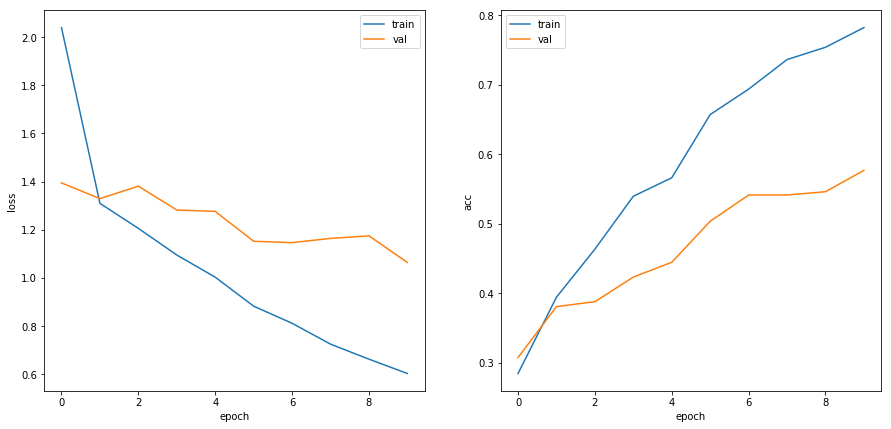

In [37]:
hist = shallow_model_loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Deep model

### Construct model

In [116]:
# input
deep_input = layers.Input(shape=(22, 1000))



# ================================== CONV1 ================================== #

# conv accross time domain
r1 = layers.Reshape((22, 1000, 1))(deep_input)
c1 = layers.Conv2D(25, (1, 10), strides=(1, 1), activation="elu")(r1)
t1 = tf.keras.layers.Permute((2, 3, 1))(c1)

# conv accross channels
r2 = layers.Reshape((991, 25*22, 1))(t1)
c2 = layers.Conv2D(25, (1, 25*22), strides=(1, 1), activation="elu")(r2)

# max pool across time domain
r3 = layers.Reshape((991, 25, 1))(c2)
maxpool3 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r3)

# =========================================================================== #



# ================================= CONV2-4 ================================= #

c4 = layers.Conv2D(50, (10, 25), strides=(1, 1), activation="elu")(maxpool3)
r4 = layers.Reshape((321, 50, 1))(c4)
maxpool4 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r4)

c5 = layers.Conv2D(100, (10, 50), strides=(1, 1), activation="elu")(maxpool4)
r5 = layers.Reshape((98, 100, 1))(c5)
maxpool5 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r5)

c6 = layers.Conv2D(200, (10, 100), strides=(1, 1), activation="elu")(maxpool5)
r6 = layers.Reshape((23, 200, 1))(c6)
maxpool6 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r6)

# =========================================================================== #

f7 = layers.Flatten()(r6)

# output
deep_output = layers.Dense(4, activation="softmax")(f7)

In [117]:
deep_model = keras.Model(inputs = deep_input, outputs = deep_output, name="deep_model")
deep_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

In [118]:
deep_model.summary()

Model: "deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 22, 1000)]        0         
_________________________________________________________________
reshape_130 (Reshape)        (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 22, 991, 25)       275       
_________________________________________________________________
permute_33 (Permute)         (None, 991, 25, 22)       0         
_________________________________________________________________
reshape_131 (Reshape)        (None, 991, 550, 1)       0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 991, 1, 25)        13775     
_________________________________________________________________
reshape_132 (Reshape)        (None, 991, 25, 1)        0

### Train model

In [119]:
deep_model_loss_hist = deep_model.fit(X_train, y_train,
                                      validation_data = (X_valid, y_valid),
                                      epochs = 10)

Train on 1692 samples, validate on 423 samples
Epoch 1/15
1692/1692 [==============================] - 15s 9ms/sample - loss: 1.3553 - acc: 0.3363 - val_loss: 1.2681 - val_acc: 0.3853
Epoch 2/15
1692/1692 [==============================] - 14s 8ms/sample - loss: 1.2863 - acc: 0.3907 - val_loss: 1.2792 - val_acc: 0.4019
Epoch 3/15
1692/1692 [==============================] - 14s 8ms/sample - loss: 1.2360 - acc: 0.4261 - val_loss: 1.2549 - val_acc: 0.4279
Epoch 4/15
1692/1692 [==============================] - 14s 8ms/sample - loss: 1.1580 - acc: 0.4947 - val_loss: 1.2982 - val_acc: 0.4303
Epoch 5/15
1692/1692 [==============================] - 14s 8ms/sample - loss: 0.9882 - acc: 0.5898 - val_loss: 1.4359 - val_acc: 0.4066
Epoch 6/15
1692/1692 [==============================] - 14s 8ms/sample - loss: 0.7375 - acc: 0.7240 - val_loss: 1.7074 - val_acc: 0.4090
Epoch 7/15
1692/1692 [==============================] - 14s 8ms/sample - loss: 0.5217 - acc: 0.8067 - val_loss: 2.0501 - val_acc: 0

# Deep model with augmentations

### Construct model

In [173]:
# after convolution and before activation we added batchnorm
# after each activation we added dropout

# input
deep_aug_input = layers.Input(shape=(22, 1000))



# ================================== CONV1 ================================== #

# conv accross time domain
r1 = layers.Reshape((22, 1000, 1), name="audnn_reshape_1_layer_1")(deep_aug_input)
c1 = layers.Conv2D(25, (1, 10), strides=(1, 1), name="audnn_conv_1_layer_1")(r1)
t1 = tf.keras.layers.Permute((2, 3, 1), name="audnn_permute_layer_1")(c1)

# # conv accross channels
r2 = layers.Reshape((991, 25*22, 1), name="audnn_reshape_2_layer_1")(t1)
c2 = layers.Conv2D(25, (1, 25*22), strides=(1, 1), name="audnn_conv_2_layer_1")(r2)
bn2 = layers.BatchNormalization(axis=1, name="audnn_bn_layer_1")(c2)                 # do I use the right filter?
a2 = layers.Activation("elu", name="audnn_act_layer_1")(bn2)


# max pool across time domain
r3 = layers.Reshape((991, 25, 1), name="audnn_reshape_3_layer_1")(a2)
maxpool3 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1), name="audnn_max_pool_layer_1")(r3)

# # =========================================================================== #



# # ================================= CONV2-4 ================================= #

c4 = layers.Conv2D(50, (10, 25), strides=(1, 1), name="audnn_conv_layer_2")(maxpool3)
bn4 = layers.BatchNormalization(axis=1, name="audnn_bn_layer_2")(c4)
a4 = layers.Activation("elu", name="audnn_act_layer_2")(bn4)
do4 = layers.Dropout(0.5, name="audnn_do_layer_2")(a4)
r4 = layers.Reshape((321, 50, 1), name="audnn_reshape_layer_2")(do4)
maxpool4 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1), name="audnn_max_pool_layer_2")(r4)


c5 = layers.Conv2D(100, (10, 50), strides=(1, 1), name="audnn_conv_layer_3")(maxpool4)
bn5 = layers.BatchNormalization(axis=1, name="audnn_bn_layer_3")(c5)
a5 = layers.Activation("elu", name="audnn_act_layer_3")(bn5)
do5 = layers.Dropout(0.5, name="audnn_do_layer_3")(a5)
r5 = layers.Reshape((98, 100, 1), name="audnn_reshape_layer_3")(do5)
maxpool5 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1), name="audnn_max_pool_layer_3")(r5)


c6 = layers.Conv2D(200, (10, 100), strides=(1, 1), name="audnn_conv_layer_4")(maxpool5)
bn6 = layers.BatchNormalization(axis=1, name="audnn_bn_layer_4")(c6)
a6 = layers.Activation("elu", name="audnn_act_layer_4")(bn6)
do6 = layers.Dropout(0.5, name="audnn_do_layer_4")(a6)
r6 = layers.Reshape((23, 200, 1), name="audnn_reshape_layer_4")(do6)
maxpool6 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1), name="audnn_max_pool_layer_4")(r6)

# # =========================================================================== #

f7 = layers.Flatten()(do6)

# output
deep_aug_output = layers.Dense(4, activation="softmax")(f7)

In [174]:
deep_aug_model = keras.Model(inputs = deep_aug_input, outputs = deep_aug_output, name="deep_aug_model")
deep_aug_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

In [175]:
deep_aug_model.summary()

Model: "deep_aug_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 22, 1000)]        0         
_________________________________________________________________
audnn_reshape_1_layer_1 (Res (None, 22, 1000, 1)       0         
_________________________________________________________________
audnn_conv_1_layer_1 (Conv2D (None, 22, 991, 25)       275       
_________________________________________________________________
audnn_permute_layer_1 (Permu (None, 991, 25, 22)       0         
_________________________________________________________________
audnn_reshape_2_layer_1 (Res (None, 991, 550, 1)       0         
_________________________________________________________________
audnn_conv_2_layer_1 (Conv2D (None, 991, 1, 25)        13775     
_________________________________________________________________
audnn_bn_layer_1 (BatchNorma (None, 991, 1, 25)     

In [172]:
deep_aug_model_loss_hist = deep_aug_model.fit(X_train, y_train,
                                      validation_data = (X_valid, y_valid),
                                      epochs = 30)

Train on 1692 samples, validate on 423 samples
Epoch 1/10
1692/1692 [==============================] - 15s 9ms/sample - loss: 0.5560 - acc: 0.7926 - val_loss: 1.1139 - val_acc: 0.5768
Epoch 2/10
1692/1692 [==============================] - 15s 9ms/sample - loss: 0.5864 - acc: 0.7671 - val_loss: 1.0563 - val_acc: 0.6028
Epoch 3/10
1692/1692 [==============================] - 16s 9ms/sample - loss: 0.5374 - acc: 0.8079 - val_loss: 0.9421 - val_acc: 0.6359
Epoch 4/10
1692/1692 [==============================] - 16s 9ms/sample - loss: 0.4940 - acc: 0.8050 - val_loss: 1.1644 - val_acc: 0.5863
Epoch 5/10
1692/1692 [==============================] - 15s 9ms/sample - loss: 0.4445 - acc: 0.8251 - val_loss: 1.6800 - val_acc: 0.4752
Epoch 6/10
1692/1692 [==============================] - 15s 9ms/sample - loss: 0.4490 - acc: 0.8304 - val_loss: 0.9795 - val_acc: 0.6312
Epoch 7/10
1692/1692 [==============================] - 14s 9ms/sample - loss: 0.4471 - acc: 0.8150 - val_loss: 1.5255 - val_acc: 0

# Results

In [171]:
shallow_model_results = shallow_model.evaluate(X_test, y_test, batch_size=128)
deep_model_results = deep_model.evaluate(X_test, y_test, batch_size=128)
deep_aug_model_results = deep_aug_model.evaluate(X_test, y_test, batch_size=128)


print('\n# Evaluate on test data')
print('Shallow model test loss, test acc:', shallow_model_results)
print('Deep model test loss, test acc:', deep_model_results)
print('Deep model with augmentations test loss, test acc:', deep_aug_model_results)

443/443 [==============================] - 1s 2ms/sample - loss: 1.0087 - acc: 0.5937

# Evaluate on test data
Shallow model test loss, test acc: [1.0690552577477277, 0.5598194]
Deep model test loss, test acc: [6.3275180401167, 0.37020317]
Deep model with augmentations test loss, test acc: [1.0086767906260006, 0.5936795]
